# Grover's Algorithm Implementation in Qiskit

**Grover's Algorithm** offers a quadratic speedup for unstructured search problems. While a classical computer requires $O(N)$ checks to find a specific item in a list of size $N$, a quantum computer can solve this in approximately $O(\sqrt{N})$ steps.

In this notebook, we implement the algorithm to find a single marked state $|w\rangle$ within a search space of size $N=32$ (which requires $n=5$ qubits). But **N** can be any number, that is a result of $n=\lceil log_2(N)$

### Step 1: Define Search Space and Target
First, we define the size of our database. We then randomly select an index to serve as our "marked" (`w_index`) element (the solution we are searching for).

In [1]:
#Size of database we are using. It can be anything, answer to any power of 2
N=32

In [2]:
from math import ceil, log2
n=ceil(log2(N))
n

5

In [3]:
from random import randint
w_index=randint(0,N-1)
print("Marked index:", w_index)

Marked index: 15


In [4]:
w_state=bin(w_index)[2:].zfill(n)
print("Marked state |w> =", w_state)
#.bin() -Binary rep of w_index
#.zfill()- provides the specified size of data

Marked state |w> = 01111


### Step 2: Initialization and Superposition
To utilize quantum parallelism, we start by creating a quantum circuit with $n$ qubits. We apply Hadamard ($H$) gates to all qubits to put the system into an **equal superposition** state:

$$|s\rangle = H^{\otimes n} |0\rangle^{\otimes n} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} |x\rangle$$

At this point, the amplitude of finding the marked state is equal to the amplitude of any other state ($1/\sqrt{N}$).

In [5]:
from qiskit import QuantumCircuit
qc=QuantumCircuit(n,n) #Need not call the registers. We can just mention the no. of bits and qubits in paranthesis

In [6]:
#Apply hgate
from qiskit.circuit.library import HGate, XGate, YGate, ZGate, CXGate
for i in range(n):
    qc.append(HGate(), [i])
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(<Qubit register=(5, "q"), index=0>, <Qubit register=(5, "q"), index=1>, <Qubit register=(5, "q"), index=2>, <Qubit register=(5, "q"), index=3>, <Qubit register=(5, "q"), index=4>), clbits=())

### Step 3: Constructing the Oracle ($U_w$)
The Oracle is a "black box" function that recognizes the solution. It flips the phase of the marked state $|w\rangle$ (multiplies it by -1) while leaving all other states unchanged.

$$U_w |x\rangle = \begin{cases} -|x\rangle & \text{if } x = w \\ |x\rangle & \text{if } x \neq w \end{cases}$$

**Implementation logic:**
1.  **Phase Flip:** We use a multi-controlled Z gate (MCZ) to flip the phase.
2.  **Addressing 0s:** The standard multi-controlled gate activates only when all control bits are '1'. If our marked state contains '0's (e.g., `10010`), we must wrap those specific qubits in $X$ gates (NOT gates) before and after the MCZ. This temporarily transforms the target state to `11111` to trigger the flip, then transforms it back.

In [7]:
#Constructing Grover oracle operator
def Grover_Oracle():
    global qc

    # Flip qubits that correspond to 0s in the marked state
    for i, bit in enumerate(w_state):
        if bit == '0':
            qc.x(i)

    # Apply MCZ (via H + MCX + H)
    qc.h(n-1)
    from qiskit.circuit.library import MCXGate
    qc.append(MCXGate(n-1), list(range(n-1)) + [n-1])
    qc.h(n-1)

    # Undo flips
    for i, bit in enumerate(w_state):
        if bit == '0':
            qc.x(i)

    qc.barrier()
    return qc

### Step 4: The Diffusion Operator ($U_s$)
The Diffusion operator (also known as the Diffuser or "Inversion about the mean") amplifies the probability amplitude of the marked state. It performs a reflection about the superposition state $|s\rangle$.

Mathematically, this is $2|s\rangle\langle s| - I$. In the circuit, this is implemented by the sequence:
1.  Apply $H$ gates to all qubits.
2.  Apply $X$ gates to all qubits.
3.  Apply a Multi-Controlled Z (MCZ).
4.  Undo the $X$ and $H$ gates.

In [8]:
#Constructing Grover's diffusion Op
def diffusion():
    global qc

    # H on all qubits
    for i in range(n):
        qc.h(i)

    # X on all qubits
    for i in range(n):
        qc.x(i)

    # MCZ
    qc.h(n-1)
    from qiskit.circuit.library import MCXGate
    qc.append(MCXGate(n-1), list(range(n-1)) + [n-1])
    qc.h(n-1)

    # Undo X
    for i in range(n):
        qc.x(i)

    # Undo H
    for i in range(n):
        qc.h(i)

    qc.barrier()
    return qc

### 5. Grover Iterations
The algorithm requires repeating the Oracle and Diffusion steps. Geometrically, each iteration rotates the state vector closer to the marked state $|w\rangle$.

We must calculate the optimal number of iterations ($t$). If we iterate too few or too many times, the probability of measuring the correct state decreases. The optimal number is approximately:

$$t \approx \frac{\pi}{4}\sqrt{N}$$

In [9]:
#Repeat the steps 3 and 4 "t" times, t=n/4(theta) -0.5
from math import asin, sqrt, pi
theta=asin(1/sqrt(N))
t=ceil(pi/(4*theta) - 0.5)
print("Grover iterations =", t)

Grover iterations = 4


In [10]:
for i in range(t): #Increasing this increasres the prob of w_state
    Grover_Oracle()
    diffusion()

### 6. Circuit Visualization
We add measurement gates to map the quantum state onto classical bits. Below is the schematic of the complete circuit, showing the initialization, the repeated Oracle-Diffuser blocks, and the final measurement.

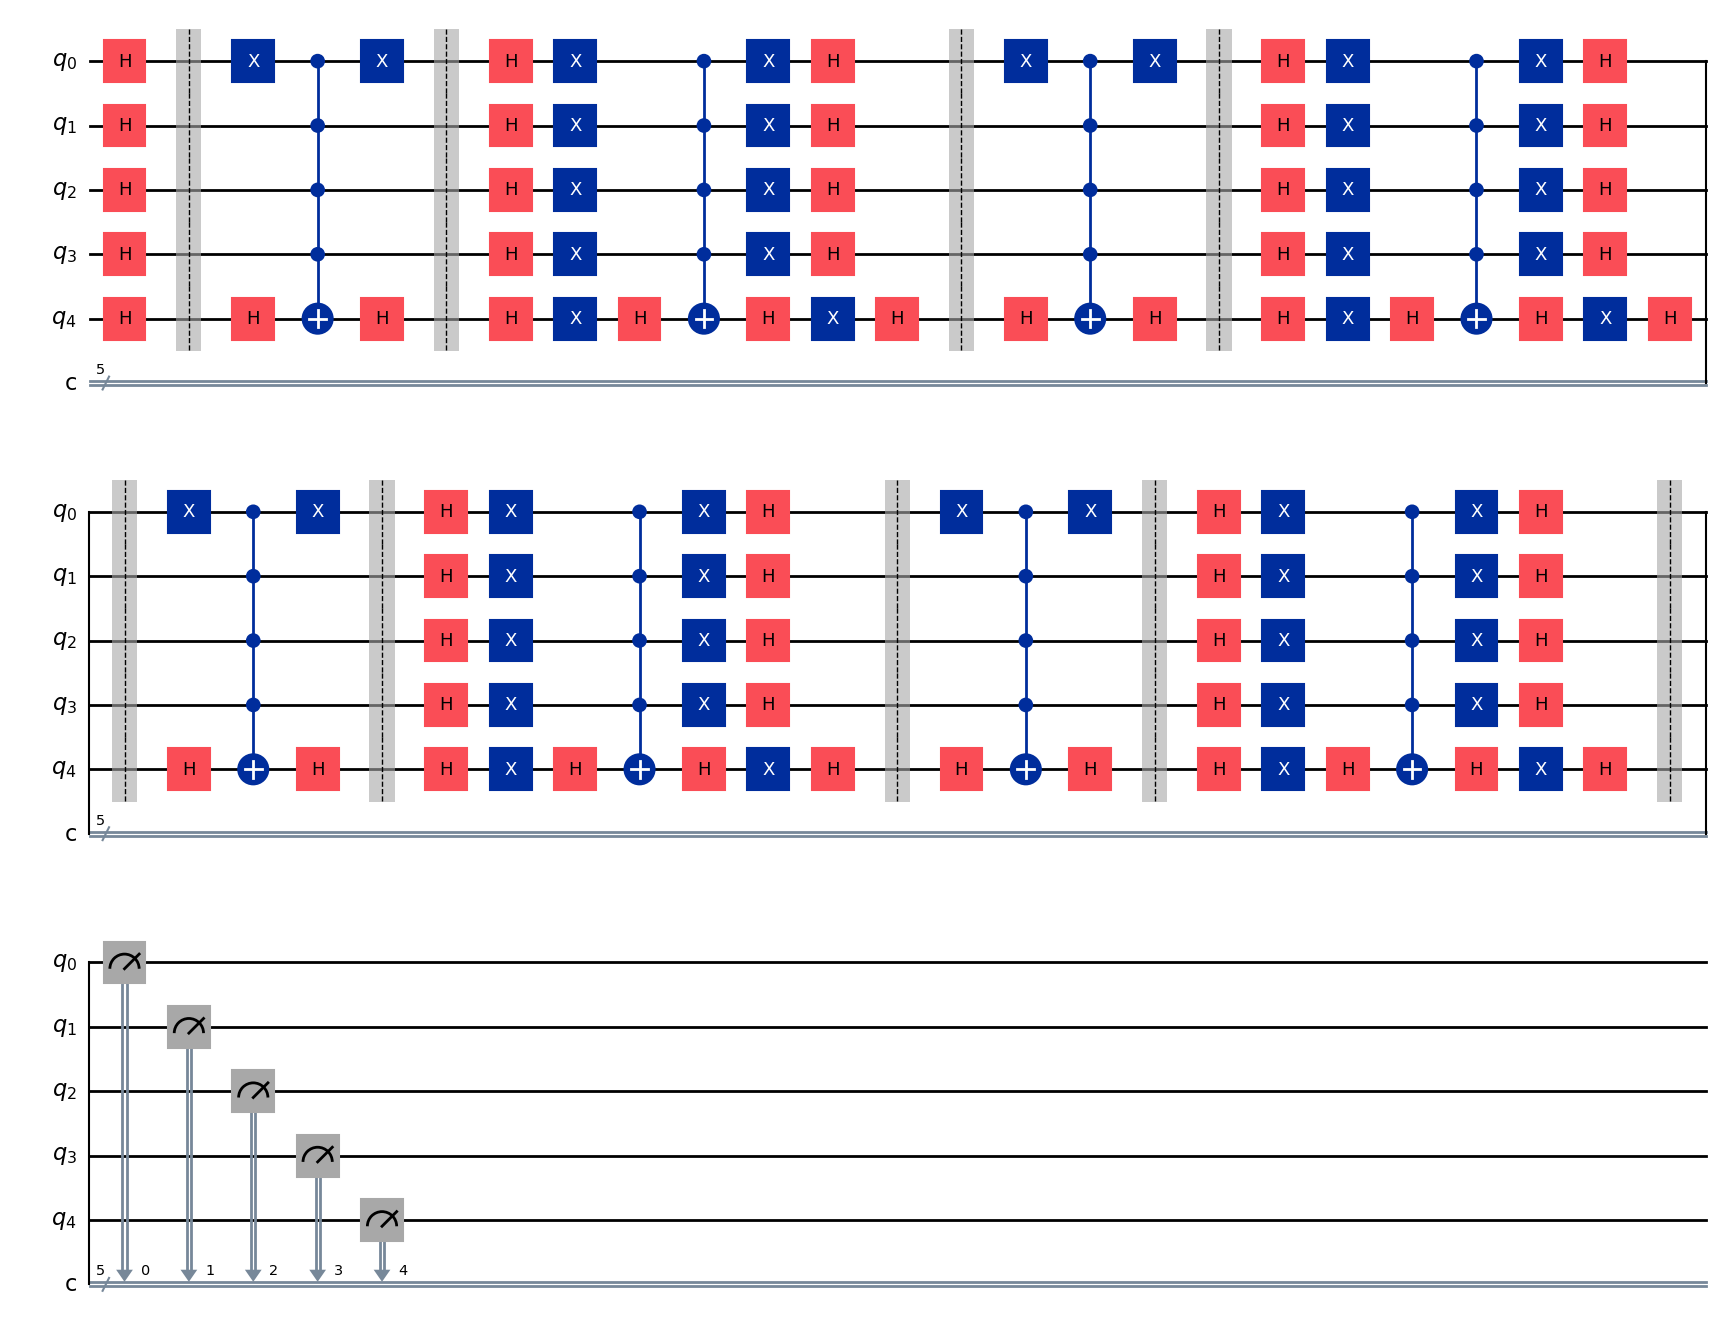

In [11]:
#Measure
for i in range(n):
    qc.measure([i], [i])
qc.draw("mpl")

### Step 7: Simulation and Execution
We now simulate the quantum circuit using Qiskit's `QasmSimulator`. We run the experiment for 1024 "shots" to generate a probability distribution of the possible outcomes.

In [12]:
from qiskit import transpile
from qiskit_aer import Aer
from qiskit_aer import QasmSimulator
backend= QasmSimulator()
qc_compile=transpile(qc, backend)
job= backend.run(qc_compile, shots=1024)
result=job.result()
counts= result.get_counts()
print(counts)

{'11110': 1023, '01111': 1}


### Step 8: Results
The histogram below displays the measurement results. We expect to see a dominant spike at the binary index corresponding to our marked state `w_index`. The other states effectively act as noise, suppressed by the diffusion operator.

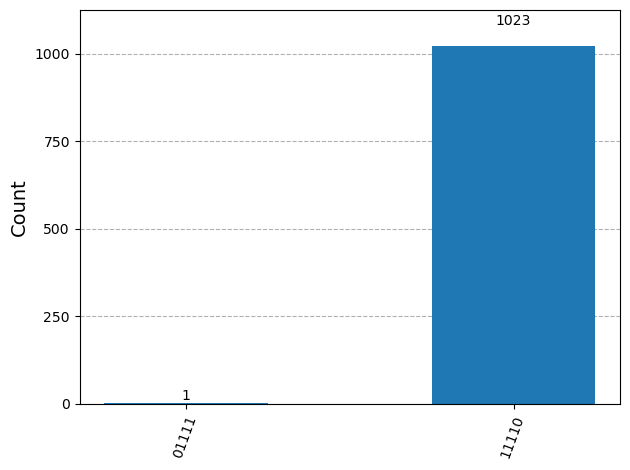

In [13]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)